## Example from MGnify summary data

1. Study MGYS00006608, 16S rRNA amplicon sequencing from the Ocean Sampling Day (OSD) campaign June 2018 (ERP124424_taxonomy_abundances_SSU_v5.0)
2. Study MGYS00006607, 16S rRNA amplicon sequencing from the Ocean Sampling Day (OSD) campaign June 2019 (ERP124431_taxonomy_abundances_SSU_v5.0)
3. Study MGYS00000492, Amplicon sequencing of Tara Oceans DNA samples corresponding to size fractions for prokaryotes or protist. (ERP003634_taxonomy_abundances_SSU_v5.0)
4. Study MGYS00006680, SOLA sampling point Raw sequence reads (SRP237882_taxonomy_abundances_SSU_v5.0)

In [11]:
# This needs to be repeated here for the Pannel dashboard to work, WEIRD
# TODO: report as possible bug
import sys
import os
import io
import warnings
import holoviews as hv

from functools import partial
warnings.filterwarnings('ignore')

import pandas as pd
import panel as pn
from dotenv import load_dotenv
load_dotenv()

from mgo.udal import UDAL

# All low level functions are imported from the momics package
from momics.loader import load_parquets_udal
from momics.metadata import get_metadata_udal, enhance_metadata
import momics.plotting as pl
from momics.panel_utils import (
    diversity_select_widgets, create_indicators_diversity,
    serve_app, close_server,
)
from momics.diversity import (
    beta_diversity_parametrized,
)

from momics.taxonomy import (
    fill_taxonomy_placeholders,
    pivot_taxonomic_data,
    remove_high_taxa,
    prevalence_cutoff_taxonomy,
)

In [2]:
# parquet files
if 'google.colab' in str(get_ipython()):
    root_folder = os.path.abspath(os.path.join('/content/momics-demos'))
else:
    root_folder = os.path.abspath(os.path.join('../'))

assets_folder = os.path.join(root_folder, 'assets')
data_folder = os.path.join(root_folder, 'data')

In [3]:
@pn.cache()
def get_data():
    return load_parquets_udal()

# Load and merge metadata
@pn.cache()
def get_full_metadata():
    return get_metadata_udal()

@pn.cache()
def get_valid_samples():
    df_valid = pd.read_csv(
        os.path.join(root_folder, 'data/shipment_b1b2_181.csv')
    )
    return df_valid

In [4]:
# Load metadata
full_metadata = get_full_metadata()

# filter the metadata only for valid 181 samples
valid_samples = get_valid_samples()
full_metadata = enhance_metadata(full_metadata, valid_samples)

# LOADing data
mgf_parquet_dfs = get_data()

In [5]:
# keep only ssu
ssu = mgf_parquet_dfs['ssu'].copy()

del mgf_parquet_dfs

### Mgnify tables are already abundance pivoted, so convert emo-bon too

In [77]:
def clean_tax_row(row):
    """
    Cleans the taxonomic row by removing empty strings and replacing spaces with underscores.
    """
    # replace string with underscores
    row = row.replace('_', '__')
    split_row = row.split(';')
    res = [split_row[1]]
    # print(split_row)
    for tax in split_row[3:]:
        if tax[-1] == '_':
            break
        res.append(tax)
    return ';'.join(res)

def clean_tax_row_osd(row):
    """
    Cleans the taxonomic row by removing empty strings and replacing spaces with underscores.
    """
    split_row = row.split(';')
    res = [split_row[0]]
    # print(split_row)
    for tax in split_row[2:]:
        if tax[-1] == '_':
            break
        res.append(tax)
    return ';'.join(res)

In [ ]:
TAXONOMY_RANKS = ['superkingdom', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
ssu_filt = fill_taxonomy_placeholders(ssu, TAXONOMY_RANKS)
ssu_filt = pivot_taxonomic_data(ssu_filt, normalize=None, rarefy_depth=None)

# remove tax id
ssu_filt = ssu_filt.drop(columns=['ncbi_tax_id'])

ssu_filt['taxonomic_concat'] = ssu_filt['taxonomic_concat'].apply(clean_tax_row)
ssu_filt.head()

,taxonomic_concat,EMOBON00001,EMOBON00003,EMOBON00004,EMOBON00005,EMOBON00006,EMOBON00007,EMOBON00008,EMOBON00009,EMOBON00010,...,EMOBON00242,EMOBON00243,EMOBON00244,EMOBON00245,EMOBON00246,EMOBON00247,EMOBON00248,EMOBON00249,EMOBON00250,EMOBON00251
0,sk__Bacteria,167,644,824,798,799,4046,4058,407,435,...,360,191,1017,328,1489,385,671,644,892,590
1,sk__Bacteria;p__Proteobacteria;c__Alphaproteob...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,sk__Bacteria;p__Proteobacteria;c__Gammaproteob...,0,0,0,0,0,1,0,0,0,...,0,0,4,1,4,1,2,3,2,4
3,sk__Bacteria;p__Proteobacteria;c__Betaproteoba...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,sk__Bacteria;p__Proteobacteria;c__Deltaproteob...,0,0,0,0,0,0,0,0,0,...,2,3,0,0,0,0,0,0,0,0


In [88]:
ssu_osd2018 = pd.read_csv(
    os.path.join(data_folder, 'mgnify_data/ERP124424_taxonomy_abundances_SSU_v5.0.tsv'),
    sep='\t')

ssu_osd2019 = pd.read_csv(
    os.path.join(data_folder, 'mgnify_data/ERP124431_taxonomy_abundances_SSU_v5.0.tsv'),
    sep='\t')

ssu_tara = pd.read_csv(
    os.path.join(data_folder, 'mgnify_data/ERP003634_taxonomy_abundances_SSU_v5.0.tsv'),
    sep='\t')

ssu_sola = pd.read_csv(
    os.path.join(data_folder, 'mgnify_data/SRP237882_taxonomy_abundances_SSU_v5.0.tsv'),
    sep='\t')

In [89]:
ssu_osd2018['#SampleID'] = ssu_osd2018['#SampleID'].apply(clean_tax_row_osd)
ssu_osd2019['#SampleID'] = ssu_osd2019['#SampleID'].apply(clean_tax_row_osd)
ssu_tara['#SampleID'] = ssu_tara['#SampleID'].apply(clean_tax_row_osd)
ssu_sola['#SampleID'] = ssu_sola['#SampleID'].apply(clean_tax_row_osd)
ssu_osd2018.head()

,#SampleID,ERR4674070,ERR4674090,ERR4674110,ERR4674160,ERR4674170,ERR4674180,ERR4674190,ERR4674041,ERR4674051,...,ERR4674038,ERR4674048,ERR4674098,ERR4674128,ERR4674138,ERR4674059,ERR4674079,ERR4674119,ERR4674149,ERR4674199
0,sk__Archaea,7,1,1,0,12,11,2,3,2,...,1,1,0,0,3,25,42,34,2,0
1,sk__Archaea;p__Candidatus_Diapherotrites,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,4,20,0,0,0
2,sk__Archaea;p__Candidatus_Woesearchaeota,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,sk__Archaea;p__Crenarchaeota,0,0,0,0,1,0,0,0,0,...,0,0,0,2,0,0,0,0,0,1
4,sk__Archaea;p__Euryarchaeota,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0


In [86]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

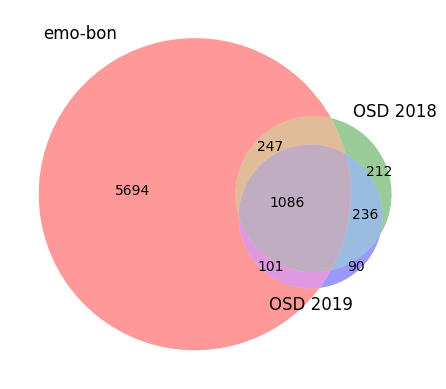

In [87]:
venn3([set(ssu_filt['taxonomic_concat'].values),
       set(ssu_osd2018['#SampleID'].values),
       set(ssu_osd2019['#SampleID'].values),
       ], ('emo-bon', 'OSD 2018', 'OSD 2019'))

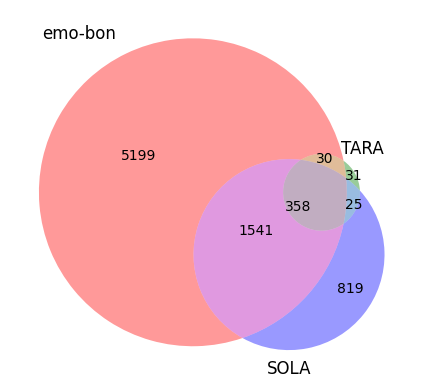

In [90]:
venn3([set(ssu_filt['taxonomic_concat'].values),
       set(ssu_tara['#SampleID'].values),
       set(ssu_sola['#SampleID'].values),
       ], ('emo-bon', 'TARA', 'SOLA'))

In [91]:
from venny4py.venny4py import *

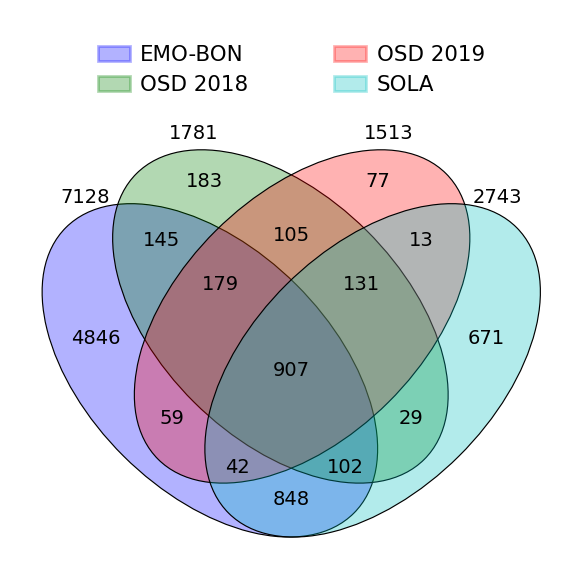

In [99]:
#dict of sets
sets = {
    'EMO-BON': set(ssu_filt['taxonomic_concat'].values),
    'OSD 2018': set(ssu_osd2018['#SampleID'].values),
    'OSD 2019': set(ssu_osd2019['#SampleID'].values),
    # 'TARA': set(ssu_tara['#SampleID'].values),
    'SOLA': set(ssu_sola['#SampleID'].values)
}

fig = venny4py(sets=sets, out = 'venn4.png')